# Pipeline for High-z Radio Galaxies I: AGN/Galaxy regression

## Introduction

Training for classification of AGN and galaxies will be done in the HETDEX Field using regression.  

Sources are all elements detected in the CatWISE2020 catalogue.  Classification will be done  
with the output of the first classification model. This time, the full dataset will be used for  
generating the model.

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, matthews_corrcoef
from sklearn.calibration import calibration_curve
import sklearn.pipeline
import ppscore as pps
import seaborn as sns
import colorcet as cc
from pycaret import classification as pyc
# from pycaret import regression as pyr
from pycaret.internal.tabular import _get_columns_to_stratify_by
import pandas as pd

In [2]:
mpl.rcdefaults()

Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [3]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

For future plots, we can configure their aspect too.

In [4]:
cmap           = cm.get_cmap('inferno')
cmap_alt       = cm.get_cmap('Dark2')
cmap_alt_2     = cm.get_cmap('Greys_r')  # Shades of grey
cmap_alt_3     = cm.get_cmap('coolwarm')  # blue to red
dark_color     = cmap(0.4)  # RGBA color code
light_color    = cmap(0.6)  # RGBA color code
colors         = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_3       = [cmap(0.25), cmap(0.50), cmap(0.75)]
colors_3_alt   = [cmap_alt(0.25), cmap_alt(0.50), cmap_alt(0.75)]
colors_3_alt_2 = [cmap_alt_2(0.25), cmap_alt_2(0.50), cmap_alt_2(0.75)]
colors_8       = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]
colors_8_alt   = [cmap_alt(0.12), cmap_alt(0.24), cmap_alt(0.35), cmap_alt(0.48), cmap_alt(0.6), cmap_alt(0.72),\
                  cmap_alt(0.84), cmap_alt(0.96)]
colors_8_alt_2 = [cmap_alt_2(0.06), cmap_alt_2(0.18), cmap_alt_2(0.29), cmap_alt_2(0.42), cmap_alt_2(0.54),\
                  cmap_alt_2(0.66), cmap_alt_2(0.78), cmap_alt_2(0.90)]
colors_8_alt_3 = [cmap_alt_3(0.06), cmap_alt_3(0.18), cmap_alt_3(0.29), cmap_alt_3(0.42), cmap_alt_3(0.54),\
                  cmap_alt_3(0.66), cmap_alt_3(0.78), cmap_alt_3(0.90)]

In [5]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

Methdods for PyCaret and saved models.

In [6]:
def get_final_column_names(pycaret_pipeline, sample_df):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        for (name, method) in pyr.get_config('prep_pipe').named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()

In [7]:
def get_feature_importances_df(pycaret_pipeline, sample_df, n = 10):
    
    final_cols = get_final_column_names(pycaret_pipeline, sample_df)
    
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        try:
            variables = pycaret_pipeline["trained_model"].feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline["trained_model"].estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    else:
        try:
            variables = pycaret_pipeline.feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline.estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    return sorted_df

***

## Reading data

In [8]:
cat_path = '../../Catalogs/'  # relative path to the same directory

We import our data using the `pandas` package.

In [9]:
save_plot_flag  = False
save_model_flag = False
load_model_flag = True

In [10]:
use_5sigma = True  # use files with 5-sigma magnitude imputation

In [11]:
mqc_version = '7_4d'  # '7_2'

In [12]:
file_name_train = f'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_{mqc_version}_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'  # 6729647 objects (6.7e6)

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [13]:
features_2_discard = ['W1mag', 'W2mag', 'objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI',\
                     'TYPE', 'Z', 'X_ray_detect', 'radio_detect', 'Total_flux_VLASS',\
                     'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [14]:
full_catalog_df = pd.read_hdf(cat_path + file_name_train, key='df').drop(columns=features_2_discard)

In [15]:
# full_catalog_df.describe()

## Random seed

In [16]:
seed = 42

#### Select confirmed galaxies and AGN, and a fraction (or all) unknown sources

In [17]:
confirmed_indices = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_AGN'] == 1)].index
unknown_indices   = full_catalog_df.drop(index=confirmed_indices).index

##### Temporary: Select a smaller sample size for testing.

In [18]:
# selected_indices = full_catalog_df.loc[unknown_indices].sample(n=2*len(confirmed_indices), random_state=seed).index
selected_indices = unknown_indices
final_indices    = confirmed_indices.union(selected_indices)

In [19]:
full_catalog_df = full_catalog_df.loc[final_indices]

Create target

$0$ for galaxies and $1$ for AGN

In [20]:
full_catalog_df['class'] = full_catalog_df.loc[:, 'is_AGN'].copy()

#### Load previous model to create labels for unknown sources.

In [21]:
# if load_model_flag:
AGN_gal_clf = pyc.load_model('models/classification_AGN_galaxy_apr_20')

Transformation Pipeline and Model Successfully Loaded


In [22]:
AGN_pred_threshold = 0.5
new_labels_train   = pyc.predict_model(AGN_gal_clf,\
                    data=full_catalog_df.loc[selected_indices],\
                    probability_threshold=AGN_pred_threshold, raw_score=True).loc[:, 'Score_1']

In [23]:
full_catalog_df.loc[selected_indices, 'class'] = new_labels_train

In [24]:
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
n_is_gal = np.sum(full_catalog_df.loc[:, 'is_gal'] == 1)
n_is_unk = len(full_catalog_df) - n_is_AGN - n_is_gal
print(f'In this dataset, with {len(full_catalog_df.loc[:, "is_AGN"])} elements,\n' +\
         f'{n_is_AGN} of them are marked as AGN, and {n_is_gal} are identified as galaxies\n' +\
         f'{n_is_unk} have no previous (confirmed) label.')

In this dataset, with 6729647 elements,
30395 of them are marked as AGN, and 55153 are identified as galaxies
6644099 have no previous (confirmed) label.


Remove intermediate targets

In [25]:
full_catalog_df = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal'])

---

Histogram of new classes (and their probabilities)

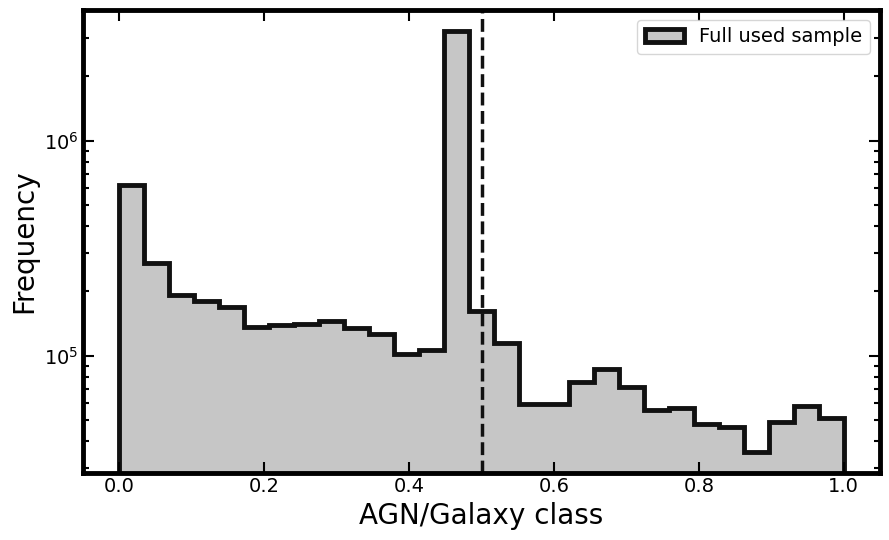

In [26]:
fig             = plt.figure(figsize=(9,5.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(full_catalog_df.loc[:, 'class'])
max_score  = np.nanmax(full_catalog_df.loc[:, 'class'])
score_bins = np.linspace(min_score, max_score, 30)

ax1.hist(full_catalog_df.loc[:, 'class'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label='Full used sample')

ax1.axvline(x=0.5, ls='--', c='k', lw=2.5)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN/Galaxy class', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
# ax1.set_xlim(left=min_score - 1e-2, right=max_score + 1e-2)
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig('plots/classes_AGN_galaxy_plus_predictions.pdf', bbox_inches='tight')
fig.tight_layout()

It is possible to select only sources that are very close to be confirmed.  
Training could be done with these sources only.

In [27]:
gal_threshold = 0.05
AGN_threshold = 0.95

In [28]:
conf_gal = np.sum((full_catalog_df.loc[:, 'class'] == 0.0))

In [29]:
conf_AGN = np.sum((full_catalog_df.loc[:, 'class'] == 1.0))

In [30]:
upgrad_AGN = np.sum((full_catalog_df.loc[:, 'class'] > AGN_threshold) & (full_catalog_df.loc[:, 'class'] < 1.00))

In [31]:
upgrad_gal = np.sum((full_catalog_df.loc[:, 'class'] > 0.00) & (full_catalog_df.loc[:, 'class'] < gal_threshold))

In [32]:
print(f'{conf_gal + conf_AGN:,}')

85,548


In [33]:
print(f'{upgrad_gal + upgrad_AGN:,}')

746,816


In [34]:
print(f'{conf_gal + upgrad_gal:,}')

753,430


In [35]:
print(f'{conf_AGN + upgrad_AGN:,}')

78,934


In [36]:
print(f'{conf_gal + conf_AGN + upgrad_gal + upgrad_AGN:,}')

832,364


In [37]:
print(f"{np.sum((full_catalog_df.loc[:, 'class'] > 0.0) & (full_catalog_df.loc[:, 'class'] < 1.0)):,}")

6,644,099


In [38]:
filter_upgrade_gal = (full_catalog_df.loc[:, 'class'] > 0.00) & (full_catalog_df.loc[:, 'class'] < gal_threshold)
filter_upgrade_AGN = (full_catalog_df.loc[:, 'class'] > AGN_threshold) & (full_catalog_df.loc[:, 'class'] < 1.00)

In [39]:
full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(filter_upgrade_gal, 0)
full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(filter_upgrade_AGN, 1)

In [40]:
full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'class'] == 0) | (full_catalog_df.loc[:, 'class'] == 1)]

In [41]:
full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].astype(int)

---

## Split data: Test, Train, Validation

In [42]:
train_test_df, validation_df = train_test_split(full_catalog_df, test_size=0.2, random_state=seed, stratify=None)

print('Shape of used data')
print('-' * 40)
print(f'Full Dataset size: {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Unseen Data For Validation: {validation_df.shape}')
print('-' * 40)

Shape of used data
----------------------------------------
Full Dataset size: (832364, 39)
Data for Modeling (Train and Test): (665891, 39)
Unseen Data For Validation: (166473, 39)
----------------------------------------


---

## Use Correlation matrix to discard some features

In [43]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [44]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [45]:
rsd_vals

class       308.285922
z_y         210.440365
i_z         138.306008
r_i          87.010499
g_r          81.577651
g_i          48.826741
J_H          37.125326
H_K          26.783452
band_num     25.411934
w2_w3        20.898750
w3_w4         9.030568
rmag          7.727747
gmag          7.399507
r/H           7.233090
g/J           6.819040
imag          6.708740
i/K           6.601470
zmag          6.379955
ymag          6.352050
z/W1          5.748582
y/W2          5.621518
W1mproPM      4.349703
w1/w4         4.280092
w1/w3         4.123480
r/z           3.504101
W2mproPM      3.250170
w2/w4         3.150313
i/y           2.828927
Hmag          1.497548
Jmag          1.438411
W3mag         1.341961
J/K           1.163563
NUVmag        1.065862
FUV/K         0.729963
Kmag          0.626993
W4mag         0.566590
FUVmag        0.388936
FUV_NUV     -18.546458
w1_w2      -137.369598
dtype: float64

In [46]:
correlation = norm_train_test_df.corr()

In [47]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [48]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [49]:
target_feat = 'class'

In [50]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [51]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [52]:
list_drop_corr

['i/K',
 'w1/w4',
 'r/H',
 'g/J',
 'w2/w4',
 'w1/w3',
 'FUV_NUV',
 'Jmag',
 'W3mag',
 'W2mproPM',
 'zmag',
 'Hmag',
 'imag',
 'J/K',
 'gmag',
 'ymag',
 'W1mproPM',
 'y/W2',
 'Kmag',
 'r/z',
 'rmag']

In [53]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [54]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [55]:
corr_discard = norm_train_test_discard.corr()

In [56]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

band_num  band_num    1.000000
FUVmag    NUVmag      0.666722
z_y       i/y         0.639830
g_r       g_i         0.617010
g_i       r_i         0.541703
i/y       i_z         0.509460
g_i       class       0.506774
class     w1_w2       0.493736
w2_w3     H_K         0.481183
band_num  w2_w3       0.470917
FUVmag    FUV/K       0.458493
w3_w4     NUVmag      0.437168
H_K       band_num    0.435908
band_num  z/W1        0.414684
W4mag     w3_w4       0.364523
dtype: float64

Text(1049.9166666666667, 0.5, 'feature')

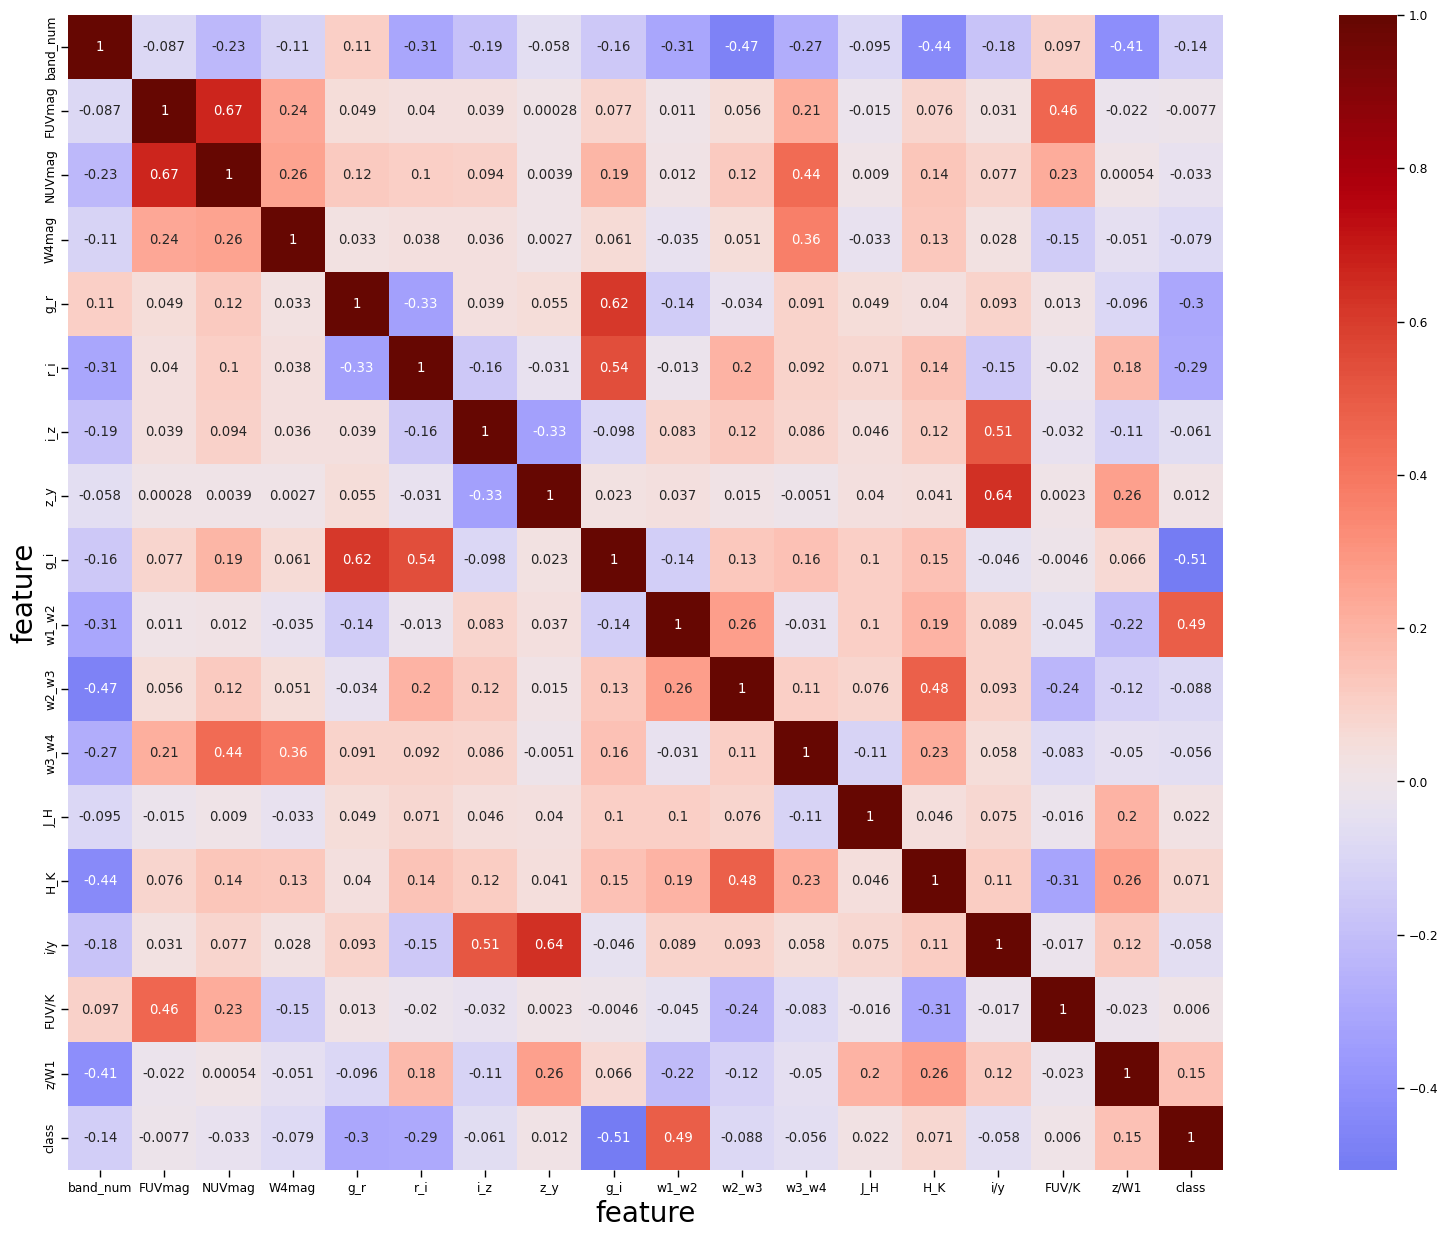

In [57]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')

In [58]:
norm_train_test_discard.loc[:, 'class'] = norm_train_test_discard.loc[:, 'class'].astype(bool)

In [59]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [60]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x         y       
FUV/K     FUV/K       1.000000
          FUVmag      0.661957
w1_w2     class       0.514631
g_i       class       0.454954
g_r       g_i         0.396077
r_i       class       0.288392
band_num  g_r         0.274445
z_y       i/y         0.270583
band_num  r_i         0.269031
r_i       g_i         0.267067
g_r       class       0.231761
r_i       g_r         0.220964
band_num  g_i         0.220740
          z/W1        0.190905
          i/y         0.189987
g_r       r_i         0.188001
class     g_i         0.179522
i/y       z_y         0.177948
g_i       g_r         0.175806
J_H       band_num    0.165584
dtype: float64

In [61]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [62]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [63]:
target_feat = 'class'

In [64]:
list_drop_pps = []

In [65]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [66]:
list_drop_pps

[]

In [67]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [68]:
pps_pred_target = pps.predictors(norm_train_test_discard, 'class', random_seed=seed)

In [69]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,w1_w2,class,0.514631,classification,True,weighted F1,0.853499,0.928893,DecisionTreeClassifier()
1,g_i,class,0.454954,classification,True,weighted F1,0.853499,0.920150,DecisionTreeClassifier()
2,r_i,class,0.288392,classification,True,weighted F1,0.853499,0.895749,DecisionTreeClassifier()
3,g_r,class,0.231761,classification,True,weighted F1,0.853499,0.887452,DecisionTreeClassifier()
4,i_z,class,0.141935,classification,True,weighted F1,0.853499,0.874293,DecisionTreeClassifier()
5,i/y,class,0.072077,classification,True,weighted F1,0.853499,0.864059,DecisionTreeClassifier()
6,band_num,class,0.065358,classification,True,weighted F1,0.853499,0.863074,DecisionTreeClassifier()
7,W4mag,class,0.012227,classification,True,weighted F1,0.853499,0.855290,DecisionTreeClassifier()
8,w3_w4,class,0.003263,classification,True,weighted F1,0.853499,0.853977,DecisionTreeClassifier()
9,NUVmag,class,0.002379,classification,True,weighted F1,0.853499,0.853848,DecisionTreeClassifier()


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [70]:
# final_feats = pps_pred_target.x.to_list()  # Before Boruta
final_feats = pps_pred_target.x.to_list()  # After Boruta

In [71]:
feats_2_discard = list_drop_corr + list_drop_pps

Boruta discards one feature.

In [75]:
exp_AGN = pyc.setup(data=train_test_df, target='class', session_id=seed, silent=True,\
                    feature_selection=False, feature_selection_method='boruta', data_split_stratify=True,\
                    numeric_features=final_feats, ignore_features=feats_2_discard, transformation=True,\
                    transformation_method='yeo-johnson', n_jobs=12, normalize=True,\
                    normalize_method='zscore', use_gpu=False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,class
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(665891, 39)"
5,Missing Values,False
6,Numeric Features,17
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [73]:
pyc.get_config('X').columns

Index(['band_num', 'FUVmag', 'NUVmag', 'W4mag', 'g_r', 'r_i', 'i_z', 'z_y',
       'g_i', 'w1_w2', 'w2_w3', 'w3_w4', 'J_H', 'H_K', 'i/y', 'FUV/K', 'z/W1'],
      dtype='object')

In [76]:
pyc.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [77]:
used_models_reg      = ['catboost', 'lightgbm', 'xgboost', 'gbr', 'et', 'rf', 'dt', 'ridge', 'lr', 'dummy']  # knn too slow, ridge does not work
final_selection_reg  = ['catboost', 'rf', 'xgboost', 'et', 'gbc', 'lightgbm', 'dummy']
n_models             = 5
top_model_AGN = pyc.compare_models(n_select=n_models, include=used_models_reg, sort='MCC')  # 1:15 hour for used_models_clf
# top_model_AGN = pyc.compare_models(n_select=n_models, sort='MCC')  # 1 hour, using all models.

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9946,0.9975,0.9659,0.9776,0.9717,0.9688,0.9688,11.4970
rf,Random Forest Classifier,0.9945,0.9963,0.9616,0.9807,0.9711,0.9680,0.9681,10.8980
xgboost,Extreme Gradient Boosting,0.9945,0.9976,0.9638,0.9777,0.9707,0.9676,0.9677,12.7780
et,Extra Trees Classifier,0.9944,0.9964,0.9613,0.9797,0.9704,0.9674,0.9674,5.2560
gbc,Gradient Boosting Classifier,0.9939,0.9965,0.9611,0.9743,0.9677,0.9643,0.9643,15.9250
lightgbm,Light Gradient Boosting Machine,0.9938,0.9968,0.9641,0.9707,0.9674,0.9640,0.9640,28.5280
knn,K Neighbors Classifier,0.9938,0.9889,0.9596,0.9749,0.9672,0.9637,0.9638,270.5220
lr,Logistic Regression,0.9915,0.9930,0.9487,0.9618,0.9552,0.9505,0.9505,0.8210
ada,Ada Boost Classifier,0.9915,0.9954,0.9478,0.9623,0.9550,0.9503,0.9503,3.7600
dt,Decision Tree Classifier,0.9910,0.9753,0.9530,0.9527,0.9529,0.9479,0.9479,1.1840


Results from `compare_models` are with ad-hoc imputation are:  

|            |Model                          |Accuracy|AUC   |Recall|Prec. |F1    |Kappa |MCC   |TT (Sec)|
|------------|-------------------------------|--------|------|------|------|------|------|------|--------|
|**xgboost** |Extreme Gradient Boosting      |0.9979  |0.9876|0.6146|0.8104|0.6989|0.6979|0.7047|92.2400 |

Thus, we select `xgboost` as meta learner.

Thus, we stack the models.

In [56]:
stacked_model_AGN = pyc.stack_models(estimator_list=top_model_AGN[1:], meta_model=top_model_AGN[0])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9505,0.9838,0.9207,0.9389,0.9297,0.8916,0.8917
1,0.9543,0.9846,0.9195,0.9502,0.9346,0.8995,0.8998
2,0.9495,0.9842,0.9177,0.9387,0.9281,0.8892,0.8893
3,0.9441,0.9806,0.9048,0.9356,0.9200,0.8770,0.8773
4,0.9451,0.9812,0.9054,0.9379,0.9214,0.8792,0.8796
5,0.9482,0.9818,0.9166,0.9364,0.9264,0.8865,0.8866
6,0.9526,0.9856,0.9266,0.9392,0.9329,0.8962,0.8963
7,0.9474,0.9842,0.9266,0.9255,0.9260,0.8852,0.8852
8,0.9572,0.9882,0.9313,0.9474,0.9393,0.9062,0.9063


In [57]:
tuned_AGN_clf = pyc.tune_model(stacked_model_AGN, early_stopping='asha', optimize='MCC')  # 20  minutes

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9503,0.9838,0.9225,0.9368,0.9296,0.8912,0.8913
1,0.9539,0.9849,0.9183,0.9502,0.9340,0.8985,0.8988
2,0.9520,0.9849,0.9183,0.9450,0.9315,0.8945,0.8948
3,0.9436,0.9808,0.9036,0.9355,0.9193,0.8760,0.8763
4,0.9441,0.9820,0.9083,0.9324,0.9202,0.8772,0.8774
5,0.9491,0.9823,0.9166,0.9386,0.9275,0.8882,0.8884
6,0.9530,0.9862,0.9248,0.9420,0.9333,0.8970,0.8971
7,0.9489,0.9841,0.9224,0.9329,0.9276,0.8881,0.8881
8,0.9549,0.9887,0.9242,0.9476,0.9358,0.9010,0.9012


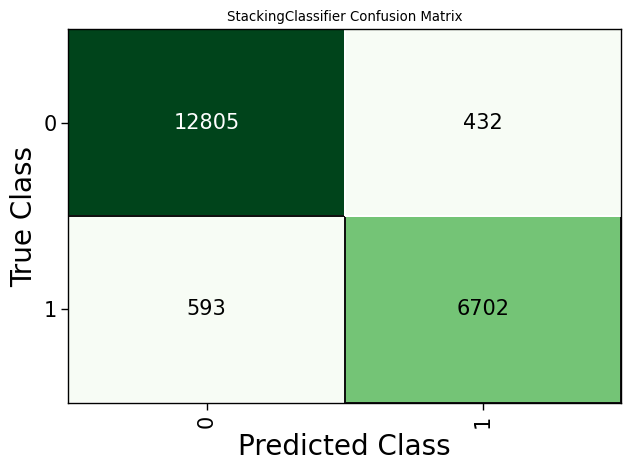

In [58]:
pyc.plot_model(tuned_AGN_clf, plot='confusion_matrix')

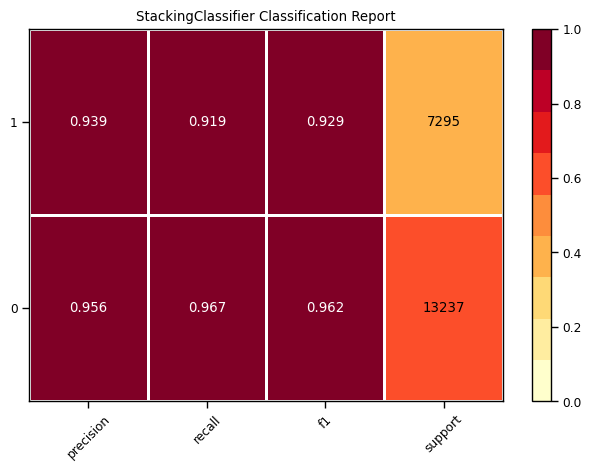

In [59]:
pyc.plot_model(tuned_AGN_clf, plot='class_report')

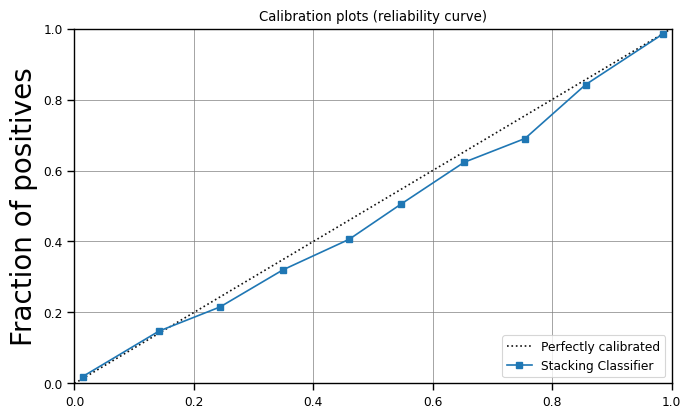

In [60]:
pyc.plot_model(tuned_AGN_clf, plot='calibration')

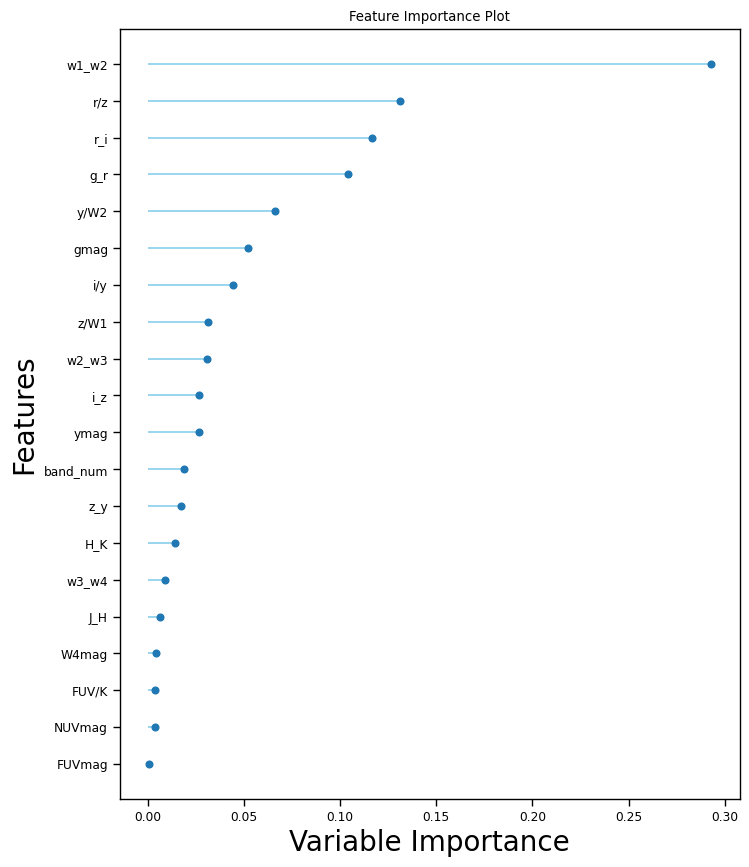

In [61]:
pyc.plot_model(tuned_AGN_clf.estimators_[0], plot='feature_all')

In [62]:
pyc.plot_model(tuned_AGN_clf, plot='parameter')

,Parameters
cv,5
estimators,"[('rf', RandomForestClassifier(bootstrap=True,..."
final_estimator,<catboost.core.CatBoostClassifier object at 0x...
n_jobs,12
passthrough,True
stack_method,auto
verbose,0


In [63]:
plt.rcParams.update(plt.rcParamsDefault)

In [64]:
pyc.predict_model(tuned_AGN_clf, probability_threshold=0.5, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9501,0.9850,0.9187,0.9394,0.9290,0.8905,0.8906


,band_num,gmag,ymag,FUVmag,NUVmag,W4mag,g_r,r_i,i_z,z_y,...,H_K,r/z,i/y,FUV/K,z/W1,y/W2,class,Label,Score_0,Score_1
0,0.330891,-0.113242,0.589152,0.157379,0.355869,0.202725,-0.864058,0.035725,-0.342749,0.164152,...,0.340844,-0.266919,-0.180432,-0.066972,0.234518,0.356623,1,1,0.0201,0.9799
1,0.757557,-1.677293,-0.898863,0.157379,-2.884640,-4.874414,-0.711718,-1.016473,-0.439741,-0.634078,...,0.340844,-1.248306,-0.976622,-0.066972,-0.522038,0.991584,1,1,0.0050,0.9950
2,-1.272924,1.382771,-0.641896,0.157379,0.355869,0.202725,2.797009,-6.370238,1.094413,5.737082,...,0.340844,-3.961715,6.134332,-0.066972,2.532855,-1.339728,0,0,0.9888,0.0112
3,-0.489590,0.217749,1.588654,0.157379,0.355869,0.202725,-0.584452,-0.504485,-0.106048,-1.099199,...,0.340844,-0.562810,-1.039337,-0.066972,0.140404,1.612456,1,1,0.0111,0.9889
4,-0.085322,0.320472,-0.555814,0.157379,0.355869,0.202725,0.921009,0.442293,0.570698,-0.019047,...,0.340844,0.869423,0.527794,-0.066972,0.525618,-0.016272,0,0,0.9908,0.0092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20527,-0.085322,-1.553072,-0.851244,0.157379,0.355869,0.202725,-0.909395,-1.305663,0.106532,-0.230889,...,0.340844,-1.033976,-0.057948,-0.066972,-1.608916,-0.761561,1,1,0.0050,0.9950
20528,1.192371,0.123455,-0.414501,0.157379,0.355869,0.202725,0.499505,0.298975,0.450346,0.031652,...,0.340844,0.633880,0.457203,-0.066972,0.337436,-0.065260,0,0,0.9840,0.0160
20529,0.330891,-0.638831,0.085842,0.157379,0.355869,0.202725,-0.579986,-0.389697,-0.398067,-0.198364,...,0.340844,-0.659760,-0.538709,-0.066972,-1.517640,-0.985219,0,1,0.4689,0.5311
20530,-0.085322,0.197329,-0.227169,0.157379,0.355869,0.202725,0.372862,0.075488,0.448544,0.244724,...,0.340844,0.405300,0.626414,-0.066972,-0.843572,-0.951424,0,0,0.9404,0.0596


In [65]:
test_prediction_clf = pyc.predict_model(tuned_AGN_clf, probability_threshold=0.5, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9501,0.9850,0.9187,0.9394,0.9290,0.8905,0.8906


Metrics from applying model to test data.  

|Model                    |Accuracy|AUC   |Recall|Prec. |F1    |Kappa |MCC   |
|-------------------------|--------|------|------|------|------|------|------|
|Extreme Gradient Boosting|0.9978  |0.9781|0.5978|0.8092|0.6876|0.6865|0.6945|

In [66]:
final_AGN_clf = pyc.finalize_model(tuned_AGN_clf)

/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pan

In [67]:
if save_model_flag:
    if use_5sigma:
        pyc.save_model(final_AGN_clf, 'models/classification_AGN_galaxy_apr_20')  # Model (it will be saved with .pkl extension)
        # pyc.save_config('../../models/config_final_HETDEX_AGN_detect_mar_28_2022')  # Configuration file

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [68]:
if load_model_flag:
    if use_5sigma:
        final_AGN_clf = pyc.load_model('models/classification_AGN_galaxy_apr_20')

### Prediction process

#### Feature importances

In [69]:
extended_data_AGN = validation_df.loc[:, get_final_column_names(final_AGN_clf, validation_df)].copy()
extended_idx_AGN  = extended_data_AGN.index
initial_cols_AGN  = extended_data_AGN.columns
extended_cols_AGN = extended_data_AGN.columns.insert(0, 'rf')
extended_cols_AGN = extended_cols_AGN.insert(0, 'lightgbm')
extended_cols_AGN = extended_cols_AGN.insert(0, 'et')
extended_cols_AGN = extended_cols_AGN.insert(0, 'xgboost')

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [70]:
print('Running data pre-processing:\n')
if isinstance(final_AGN_clf, sklearn.pipeline.Pipeline):
    prep_steps = final_AGN_clf.named_steps.items()
else:
    prep_steps = pyc.get_config('prep_pipe').named_steps.items()

for (name, method) in prep_steps:
    if method != 'passthrough':  # and name != 'trained_model':
        print(f'Running {name}')
        extended_data_AGN = method.transform(extended_data_AGN)
extended_data_AGN_df = pd.DataFrame(extended_data_AGN, columns=extended_cols_AGN, index=extended_idx_AGN)

Running data pre-processing:

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [71]:
if isinstance(final_AGN_clf, sklearn.pipeline.Pipeline):
    importances_coef = final_AGN_clf.named_steps['trained_model'].final_estimator_.feature_importances_
else:
    importances_coef = final_AGN_clf.final_estimator_.feature_importances_

coef_meta_df = pd.DataFrame({'Feature': extended_cols_AGN, 'Importance': importances_coef})
coef_sorted_meta_df = (
    coef_meta_df.sort_values(by='Importance', ascending=False)
    .head(len(extended_cols_AGN))
    .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [72]:
if isinstance(final_AGN_clf, sklearn.pipeline.Pipeline):
    estimators_list  = ffinal_AGN_clf.named_steps['trained_model'].estimators
    estimators_list_ = ffinal_AGN_clf.named_steps['trained_model'].estimators_
else:
    estimators_list  = final_AGN_clf.estimators
    estimators_list_ = final_AGN_clf.estimators_

In [73]:
base_models_names = [model[0] for model in estimators_list]

In [74]:
coef_sorted_base_df = {}

In [75]:
for model, model_fit in zip(base_models_names, estimators_list_):
    coef_base_df = pd.DataFrame({'Feature': extended_cols_AGN.drop(base_models_names),
                                 'Importance': model_fit.feature_importances_})
    coef_sorted_base_df[model] = (
    coef_base_df.sort_values(by='Importance', ascending=False)
    .head(len(extended_cols_AGN.drop(base_models_names)))
    .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [77]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [78]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for rf...
Calculating for lightgbm...
Calculating for et...
Calculating for xgboost...


rf             lightgbm                   et              xgboost  \
     Feature Importance   Feature Importance   Feature Importance   Feature   
0      w1_w2  28.783206     w1_w2  10.800000     w1_w2  33.494765     w1_w2   
1        r/z  13.748579     w2_w3  10.266667      gmag  10.407363       r/z   
2        r_i  11.148273       g_r   9.300000       g_r   7.486392      y/W2   
3        g_r  10.613189       r/z   8.166667      ymag   7.184761     w2_w3   
4       y/W2   6.622074      gmag   6.866667       r/z   6.642163     w3_w4   
5       gmag   5.085958      ymag   6.433333      y/W2   5.605816       g_r   
6        i/y   4.476994      z/W1   6.433333       r_i   4.950921      ymag   
7       ymag   3.210881       r_i   6.300000  band_num   4.176399      gmag   
8       z/W1   2.998381      y/W2   6.233333      z/W1   3.768177     W4mag   
9      w2_w3   2.904613       i/y   5.566667       i/y   3.499426  band_num   
10       i_z   2.713932       i_z   5.300000     w2_w3   3.303939      z/W1   
11  band_num   2.049536     w3_w4   4.533333       i_z   2.318488       r_i   
12       z_y   1.723387  band_num   3.633333       z_y   1.966051    NUVmag   
13       H_K   1.158558       z_y   3.433333     w3_w4   1.279290       i/y   
14     w3_w4   0.894215    NUVmag   1.733333       H_K   0.913196       i_z   
15       J_H   0.650241       H_K   1.566667     W4mag   0.909582       H_K   
16    NUVmag   0.378724     W4mag   1.333333    NUVmag   0.847589     FUV/K   
17     FUV/K   0.377080     FUV/K   1.066667       J_H   0.554468       z_y   
18     W4mag   0.358987       J_H   1.000000     FUV/K   0.374660       J_H   
19    FUVmag   0.103193    FUVmag   0.033333    FUVmag   0.316553    FUVmag   

               
   Importance  
0   55.967968  
1   10.332925  
2    5.842956  
3    4.290623  
4    2.953234  
5    2.546161  
6    2.457378  
7    2.410675  
8    1.576698  
9    1.543132  
10   1.508464  
11   1.475048  
12   1.364476  
13   1.089148  
14   1.042412  
15   0.831650  
16   0.777145  
17   0.773110  
18   0.630705  
19   0.586099

In [79]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
print('Meta model')
display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance
0,et,31.810909
1,rf,27.565594
2,xgboost,12.483650
3,lightgbm,10.144322
4,w2_w3,2.938423
5,w1_w2,2.107527
6,ymag,1.927292
7,gmag,1.837488
8,r_i,1.595995
9,r/z,1.156308


Feature importances scaled to sum 100
Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
--------------------
top features:
Feature	Importance
w1_w2	10.829
w2_w3	10.260
g_r	9.298
r/z	8.169
gmag	6.866
ymag	6.431
z/W1	6.430
r_i	6.300
y/W2	6.233
i/y	5.564
i_z	5.297
w3_w4	4.531
band_num	3.632
z_y	3.431
NUVmag	1.732
H_K	1.566
W4mag	1.333
FUV/K	1.066
J_H	1.000
FUVmag	0.034


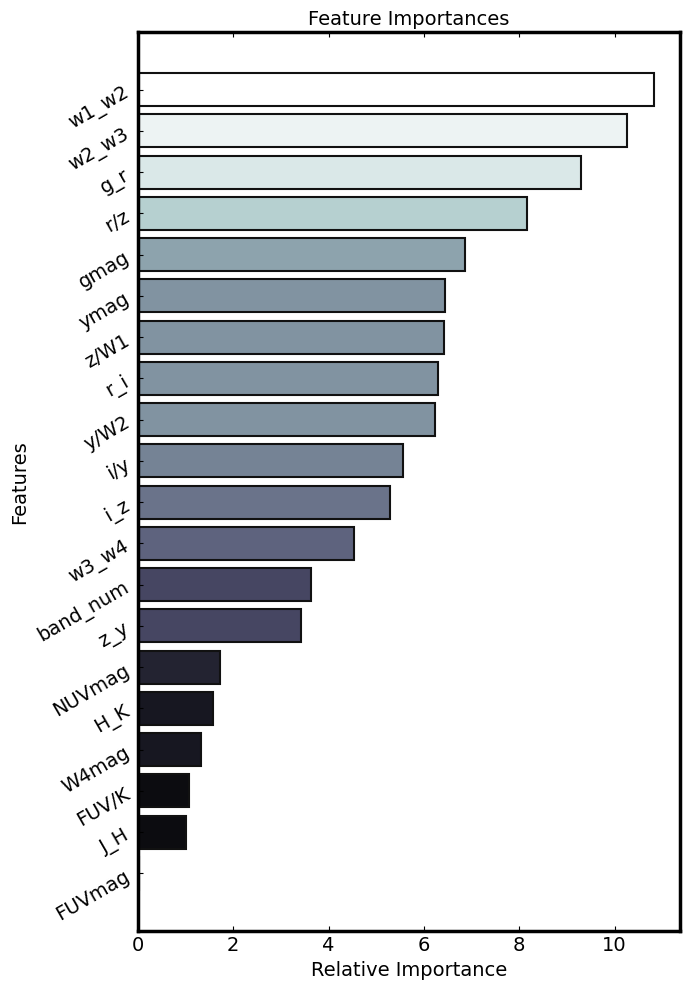

In [80]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    n_top       = len(validation_df.columns)
    features_df = get_feature_importances_df(final_AGN_clf, validation_df, n=n_top)
    features    = features_df.loc[:, 'Feature'].to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal = importances / np.nansum(importances)
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    # indices     = np.argsort(importances)[-n_top:] #only show most important features
    # indices     = np.argsort(importances)
    # ax1.set_title(f'{model_name} Feature Importances', size=14)
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), import_scal * 100,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    # plt.yticks(range(len(importances)), [features[i] for i in importances])
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    # ax1.set_xscale('log')
    # plt.show()
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig('plots/feat_imp_classification_AGN_galaxy.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(import_scal  * 100)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

In [81]:
AGN_pred_threshold = 0.5
# AGN_pred_threshold = 0.49999523  # from MCC optimisation - From S82 data

In [82]:
validation_prediction_clf = pyc.predict_model(final_AGN_clf, data=validation_df, probability_threshold=AGN_pred_threshold, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9490,0.9847,0.9118,0.9428,0.9271,0.8879,0.8882


Create confusion matrix with validation data.

In [83]:
cm_mat_val = np.array([[np.sum(np.array(validation_prediction_clf['class'] == 0) & np.array(validation_prediction_clf['Label'] == 0)),\
          np.sum(np.array(validation_prediction_clf['class'] == 0) & np.array(validation_prediction_clf['Label'] ==1))],\
        [np.sum(np.array(validation_prediction_clf['class'] == 1) & np.array(validation_prediction_clf['Label'] == 0)),\
          np.sum(np.array(validation_prediction_clf['class'] == 1) & np.array(validation_prediction_clf['Label'] ==1))]])

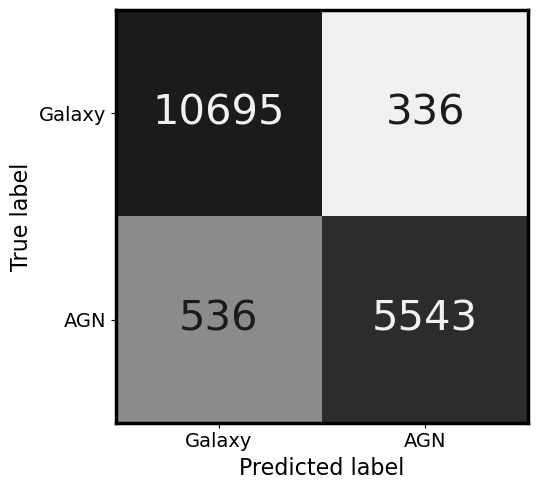

In [84]:
from sklearn.metrics import ConfusionMatrixDisplay

fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mat_val,
                              display_labels=['Galaxy', 'AGN'])
norm = ImageNormalize(stretch=LogStretch())

# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp_b = disp.plot(include_values=True,
                 cmap=cm.get_cmap('cet_dimgray_r'), ax=ax1, xticks_rotation='horizontal')

for text_val in disp_b.text_.flatten():
    text_val.set_fontsize(30)
clb = plt.gca().images[-1].colorbar
clb.ax.tick_params(labelsize=14)
clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Sources in bin', size=14, path_effects=pe2)
clb.remove()

disp_b.im_.norm = norm

ax1.xaxis.get_label().set_fontsize(16)
ax1.yaxis.get_label().set_fontsize(16)

ax1.tick_params(axis='both', which='major', labelsize=14)

plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('plots/conf_matrix_validation_classification_AGN_galaxy.pdf', bbox_inches='tight')
plt.show()

In [85]:
TN_AGN, FP_AGN, FN_AGN, TP_AGN = cm_mat_val.flatten().astype('float32')

In [86]:
MCC_AGN_val = ((TP_AGN * TN_AGN) - (FP_AGN * FN_AGN)) /\
            np.sqrt((TP_AGN + FP_AGN) * (TP_AGN + FN_AGN) * (TN_AGN + FP_AGN) * (TN_AGN + FN_AGN))

ACC_AGN_val = (TP_AGN + TN_AGN) / (TP_AGN + TN_AGN + FP_AGN + FN_AGN)

F1_AGN_val  = 2 * TP_AGN / (2 * TP_AGN + FP_AGN + FN_AGN)

Recall_AGN_val = TP_AGN / (TP_AGN + FN_AGN)

In [87]:
print('Metrics for Validation set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_AGN_val:.4f}')
print(f'Accuracy is ACC = {ACC_AGN_val:.4f}')
print(f'F1-score is F1 = {F1_AGN_val:.4f}')
print(f'Recall is TPR = {Recall_AGN_val:.4f}')

Metrics for Validation set.
Matthews Correlation Coefficient is MCC = 0.8882
Accuracy is ACC = 0.9490
F1-score is F1 = 0.9271
Recall is TPR = 0.9118


In [88]:
train_size         = 0.7
data_split_shuffle = True
_stratify_columns = _get_columns_to_stratify_by(
            train_test_df.drop(columns=['class']), train_test_df.loc[:, 'class'], False, 'class'
        )

X_train, X_test, y_train, y_test = train_test_split(
                train_test_df.drop(columns=['class']),
                train_test_df.loc[:, 'class'],
                test_size=1 - train_size,
                stratify=_stratify_columns,
                random_state=seed,
                shuffle=data_split_shuffle,
            )
train_data_df        = pd.concat([X_train, y_train], axis=1)
test_data_df         = pd.concat([X_test, y_test], axis=1)

In [89]:
train_prediction_clf = pyc.predict_model(final_AGN_clf, data=train_data_df, probability_threshold=AGN_pred_threshold, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9815,0.9993,0.9590,0.9889,0.9737,0.9595,0.9598


In [90]:
test_prediction_clf = pyc.predict_model(final_AGN_clf, data=test_data_df, probability_threshold=AGN_pred_threshold, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9833,0.9993,0.9618,0.9906,0.9760,0.9632,0.9635


In [91]:
cm_mat_train = np.array([[np.sum(np.array(train_prediction_clf['class'] == 0) & np.array(train_prediction_clf['Label'] == 0)),\
          np.sum(np.array(train_prediction_clf['class'] == 0) & np.array(train_prediction_clf['Label'] ==1))],\
        [np.sum(np.array(train_prediction_clf['class'] == 1) & np.array(train_prediction_clf['Label'] == 0)),\
          np.sum(np.array(train_prediction_clf['class'] == 1) & np.array(train_prediction_clf['Label'] ==1))]])

In [92]:
cm_mat_test = np.array([[np.sum(np.array(test_prediction_clf['class'] == 0) & np.array(test_prediction_clf['Label'] == 0)),\
          np.sum(np.array(test_prediction_clf['class'] == 0) & np.array(test_prediction_clf['Label'] ==1))],\
        [np.sum(np.array(test_prediction_clf['class'] == 1) & np.array(test_prediction_clf['Label'] == 0)),\
          np.sum(np.array(test_prediction_clf['class'] == 1) & np.array(test_prediction_clf['Label'] ==1))]])

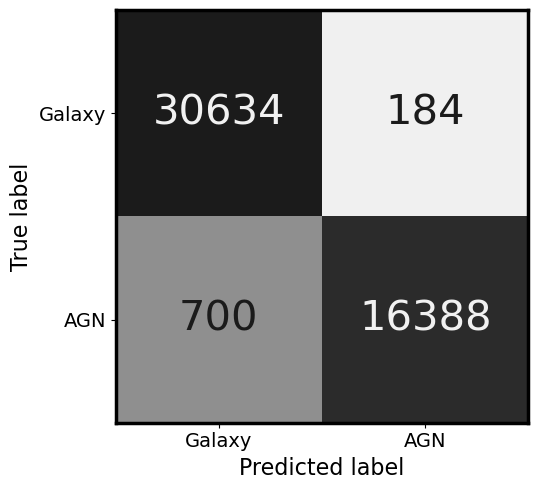

In [93]:
from sklearn.metrics import ConfusionMatrixDisplay

fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mat_train,
                              display_labels=['Galaxy', 'AGN'])
norm = ImageNormalize(stretch=LogStretch())

# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp_b = disp.plot(include_values=True,
                 cmap=cm.get_cmap('cet_dimgray_r'), ax=ax1, xticks_rotation='horizontal')

for text_val in disp_b.text_.flatten():
    text_val.set_fontsize(30)
clb = plt.gca().images[-1].colorbar
clb.ax.tick_params(labelsize=14)
clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Sources in bin', size=14, path_effects=pe2)
clb.remove()

disp_b.im_.norm = norm

ax1.xaxis.get_label().set_fontsize(16)
ax1.yaxis.get_label().set_fontsize(16)

ax1.tick_params(axis='both', which='major', labelsize=14)

plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('plots/conf_matrix_train_classification_AGN_galaxy.pdf', bbox_inches='tight')
plt.show()

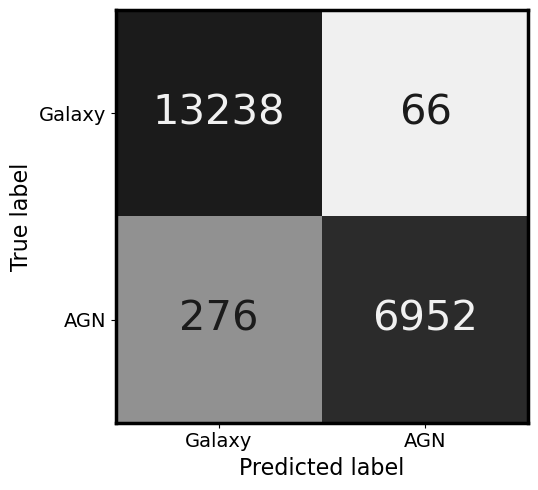

In [94]:
from sklearn.metrics import ConfusionMatrixDisplay

fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mat_test,
                              display_labels=['Galaxy', 'AGN'])
norm = ImageNormalize(stretch=LogStretch())

# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp_b = disp.plot(include_values=True,
                 cmap=cm.get_cmap('cet_dimgray_r'), ax=ax1, xticks_rotation='horizontal')

for text_val in disp_b.text_.flatten():
    text_val.set_fontsize(30)
clb = plt.gca().images[-1].colorbar
clb.ax.tick_params(labelsize=14)
clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Sources in bin', size=14, path_effects=pe2)
clb.remove()

disp_b.im_.norm = norm

ax1.xaxis.get_label().set_fontsize(16)
ax1.yaxis.get_label().set_fontsize(16)

ax1.tick_params(axis='both', which='major', labelsize=14)

plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('plots/conf_matrix_test_classification_AGN_galaxy.pdf', bbox_inches='tight')
plt.show()

In [95]:
TN_AGN_train, FP_AGN_train, FN_AGN_train, TP_AGN_train = cm_mat_train.flatten().astype('float32')

In [96]:
MCC_AGN_train = ((TP_AGN_train * TN_AGN_train) - (FP_AGN_train * FN_AGN_train)) /\
            np.sqrt((TP_AGN_train + FP_AGN_train) * (TP_AGN_train + FN_AGN_train) * 
                    (TN_AGN_train + FP_AGN_train) * (TN_AGN_train + FN_AGN_train))

ACC_AGN_train = (TP_AGN_train + TN_AGN_train) / (TP_AGN_train + TN_AGN_train + FP_AGN_train + FN_AGN_train)

F1_AGN_train  = 2 * TP_AGN_train / (2 * TP_AGN_train + FP_AGN_train + FN_AGN_train)

Recall_AGN_train = TP_AGN_train / (TP_AGN_train + FN_AGN_train)

In [97]:
print('Metrics for Training set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_AGN_train:.4f}')
print(f'Accuracy is ACC = {ACC_AGN_train:.4f}')
print(f'F1-score is F1 = {F1_AGN_train:.4f}')
print(f'Recall is TPR = {Recall_AGN_train:.4f}')

Metrics for Training set.
Matthews Correlation Coefficient is MCC = 0.9598
Accuracy is ACC = 0.9815
F1-score is F1 = 0.9737
Recall is TPR = 0.9590


In [98]:
TN_AGN_test, FP_AGN_test, FN_AGN_test, TP_AGN_test = cm_mat_test.flatten().astype('float32')

In [99]:
MCC_AGN_test = ((TP_AGN_test * TN_AGN_test) - (FP_AGN_test * FN_AGN_test)) /\
            np.sqrt((TP_AGN_test + FP_AGN_test) * (TP_AGN_test + FN_AGN_test) * 
                    (TN_AGN_test + FP_AGN_test) * (TN_AGN_test + FN_AGN_test))

ACC_AGN_test = (TP_AGN_test + TN_AGN_test) / (TP_AGN_test + TN_AGN_test + FP_AGN_test + FN_AGN_test)

F1_AGN_test  = 2 * TP_AGN_test / (2 * TP_AGN_test + FP_AGN_test + FN_AGN_test)

Recall_AGN_test = TP_AGN_test / (TP_AGN_test + FN_AGN_test)

In [100]:
print('Metrics for Test set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_AGN_test:.4f}')
print(f'Accuracy is ACC = {ACC_AGN_test:.4f}')
print(f'F1-score is F1 = {F1_AGN_test:.4f}')
print(f'Recall is TPR = {Recall_AGN_test:.4f}')

Metrics for Test set.
Matthews Correlation Coefficient is MCC = 0.9635
Accuracy is ACC = 0.9833
F1-score is F1 = 0.9760
Recall is TPR = 0.9618


Calculate ROC AUC values and plots.

In [101]:
roc_auc_train      = roc_auc_score(train_prediction_clf.loc[:, 'class'],      train_prediction_clf.loc[:, 'Score_1'])
roc_auc_test       = roc_auc_score(test_prediction_clf.loc[:, 'class'],       test_prediction_clf.loc[:, 'Score_1'])
roc_auc_validation = roc_auc_score(validation_prediction_clf.loc[:, 'class'], validation_prediction_clf.loc[:, 'Score_1'])

In [102]:
print(f'Area under the curve (ROC) for training   = {roc_auc_train:.5f}')
print(f'Area under the curve (ROC) for test       = {roc_auc_test:.5f}')
print(f'Area under the curve (ROC) for validation = {roc_auc_validation:.5f}')

Area under the curve (ROC) for training   = 0.99925
Area under the curve (ROC) for test       = 0.99929
Area under the curve (ROC) for validation = 0.98474


In [103]:
fpr_train, tpr_train, thresh_train = roc_curve(train_prediction_clf.loc[:, 'class'],      train_prediction_clf.loc[:, 'Score_1'])
fpr_test,  tpr_test,  thresh_test  = roc_curve(test_prediction_clf.loc[:, 'class'],       test_prediction_clf.loc[:, 'Score_1'])
fpr_val,   tpr_val,   thresh_val   = roc_curve(validation_prediction_clf.loc[:, 'class'], validation_prediction_clf.loc[:, 'Score_1'])

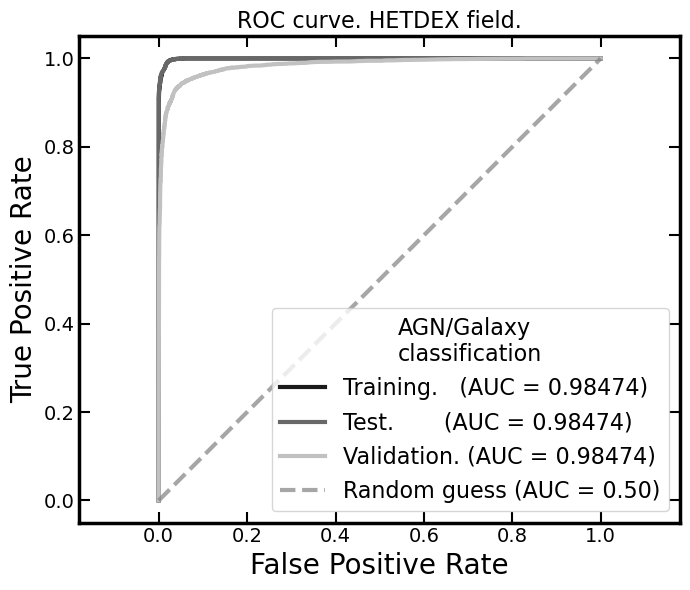

/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future re

In [104]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train = RocCurveDisplay(fpr=fpr_train, tpr=tpr_train, roc_auc=roc_auc_train)
viz_test  = RocCurveDisplay(fpr=fpr_test,  tpr=tpr_test,  roc_auc=roc_auc_test)
viz_val   = RocCurveDisplay(fpr=fpr_val,   tpr=tpr_val,   roc_auc=roc_auc_validation)
viz_train.plot(ax=ax1, lw=3, c=cm.get_cmap('cet_dimgray')(0.0), label=f"Training.   (AUC = {roc_auc_train:0.5f})")
viz_test.plot(ax=ax1,  lw=3, c=cm.get_cmap('cet_dimgray')(0.4), label=f"Test.       (AUC = {roc_auc_test:0.5f})")
viz_val.plot(ax=ax1,   lw=3, c=cm.get_cmap('cet_dimgray')(0.8), label=f"Validation. (AUC = {roc_auc_validation:0.5f})")

ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('False Positive Rate', fontsize=20)
ax1.set_ylabel('True Positive Rate', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=4, fontsize=16, title='AGN/Galaxy\nclassification', title_fontsize=16)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('ROC curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig('plots/AUC_ROC_classification_AGN_galaxy.pdf', bbox_inches='tight')
plt.show()